# Segmenting and Clustering Neighborhoods in Toronto

<h3>Introduction</h3>
<p>
This is an assignment for the Introduction to Artifical Intelligence course (SOFE 3720U). Within this we will be explore how to segement and cluster the neighborhoods in Toronto. 
</p>

<h3>Import Statements</h3>

In [83]:
from dotenv import load_dotenv
from dotenv import dotenv_values

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
import geojson

import requests
from pandas import json_normalize

import folium

from bs4 import BeautifulSoup as bs

from sklearn.cluster import KMeans
from sklearn import preprocessing

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

print('Libraries Imported')

Libraries Imported


<h3>
Setting up Foursquare API and defining custom functions
</h3>

In [84]:
#Import the hidden values within the .env file, these values are keys used to access API
config = dotenv_values(".env")
#Assign url variable to initialize API
url = "https://api.foursquare.com/v3/places/nearby"
#Assign header which will allow us to access the website by passing through keys 
headers = {"Accept": "application/json","Authorization": config["API_KEY"]}
#Create the request statement which allows to freely use API
response = requests.request("GET", url, headers=headers)

#Initialize and define findNearbyVenues function
#The purpose of this function is to use the Foursquare API and find venues using parameters entered
#Paarameters are set to none initially in the event the parameter isnt entered
def findNearbyVenues(location=None, categories=None, limit="50"):
    #Create url based on the exisiting values passed through
    if(location and categories == None):
        url = "https://api.foursquare.com/v3/places/search?" + "near=" + str(location[0]) + "%2C" + str(location[1]) + "&limit=" + limit
    elif(location and categories):
        url = "https://api.foursquare.com/v3/places/search?" + "categories=" + categories + "&near=" + str(location[0]) + "%2C" + str(location[1]) + "&limit=" + limit

    #Create the response statement from requesting from API
    response = requests.request("GET", url, headers=headers)
    #Return the result if the code was successful
    if(response.status_code == 200):
        return response.json()

#Initialize and define getVenues function
#The purpose of this function is to find venues using neighbourhoods using the findNearbyVenues function
def getVenues(names, latitudes, longitudes):
    #Initialize list to hold values
    venuesList = []
    #Loop through neighbourhoods
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        #Request nearby venues using Foursquare API
        results = findNearbyVenues(location=[lat,lng], limit="50")
        venues = results['results']
        #If neighbourhood has venues
        if(len(venues) > 0):
            #Attempt to appended all the values to the list
            try:
                venuesList.append([(
                name, 
                lat, 
                lng, 
                venue['name'], 
                venue['geocodes']['main']['latitude'], 
                venue['geocodes']['main']['longitude'], venue['categories'][0]['name']) for venue in venues])
            #If it doesn't work skip neighbourhood
            except:
                continue
    #Create dataframe with all the data collected
    dfNearbyVenues = pd.DataFrame([item for venuesList in venuesList for item in venuesList])
    #Give the dataframe columns
    dfNearbyVenues.columns = ['Neighbourhood','Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude',  'Venue Category']
    return(dfNearbyVenues)

#Initialize and define commonVenues function
#The purpose of this function is sort the venues by catergories 
def commonVenues(row, topVenues):
    rowCategories = row.iloc[1:]
    rowCategoriesSorted = rowCategories.sort_values(ascending=False)
    
    return rowCategoriesSorted.index.values[0:topVenues]

print('API initialize and custom functions created')

API initialize and custom functions created


<h3>Week 1 - Foursquare API</h3>
<p>
Within this section we will be using the Foursquare API to find latitude, longitude, and venues within the Toronto area.
</p>

<h4>
Creating Stations dataframe using the findNearbyVenues function
</h4>

In [85]:
#Assign lat and long for Toronto
latitude = 43.6532 
longitude = -79.3832
#Creating police stations data frame
#Assign result variable use the custom function with the parameters below
results = findNearbyVenues(location = ["Toronto", "ON"], categories="12070", limit="50")
#Normalize the results to be able to changed
dfStations = json_normalize(results['results'], max_level=3)
#Drop unnecessary columns
dfStations.drop(dfStations.columns[[0,1,2,3,4,6,9,10,13,19]], axis=1, inplace=True)
#Display first five rows
dfStations.head()

,name,geocodes.main.latitude,geocodes.main.longitude,location.address,location.country,location.formatted_address,location.locality,location.neighborhood,location.postcode,location.region
0,53 Division Toronto Police Service,43.706104,-79.400647,75 Eglinton Ave W,CA,"75 Eglinton Ave W (at Duplex Ave.), Toronto ON...",Toronto,[Yonge and Eglinton],M4R 2G9,ON
1,Toronto Police Service - 13 Division,43.698433,-79.436581,1435 Eglinton Ave W,CA,"1435 Eglinton Ave W (Allen Expressway), Toront...",Toronto,[York],M6C 3Z4,ON
2,Toronto Fire Station 341,43.694398,-79.441081,555 Oakwood Ave,CA,"555 Oakwood Ave, Toronto ON M6E 2X4",Toronto,NaN,M6E 2X4,ON
3,Toronto Fire Station 131,43.726175,-79.402729,3135 Yonge St,CA,"3135 Yonge St (Wanless Ave), Toronto ON M4N 2K8",Toronto,NaN,M4N 2K8,ON
4,University of Toronto Campus Community Police,43.664817,-79.400841,21 Sussex Ave,CA,"21 Sussex Ave (btwn Huron & St. George), Toron...",Toronto,[Susex Ulster],M5S 1J6,ON


<h4>
Creating dataframe using the function created to use Foursquare API
</h4>

In [86]:
#Create the map which is based on the coordinates for Toronto
mapWithMarkers = folium.Map(location=[latitude, longitude], zoom_start=10)
#Display Map
mapWithMarkers

<h3>Week 2 - Prepare your data</h3>
<p>
Within this section we will be using the provide source to create a large dataframe which contains the neccessary information for the choosen correlations
</p>

<h4>
Creating Neighbourhood data frame using wikipedia link
</h4>

In [87]:
#Creating Neighbourhood data frame
#Add url of wikipedia page that will be scrap for data
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050'
#Create a request for the data within url
temp = requests.get(url)
#Take only text from the url
data = temp.text
#Parse the html to make it easier to navigate
soup = bs(data,'html.parser')
#Find table element 
wiki = soup.find('table')
#Read and assign data from table to data frame
df = pd.read_html(str(wiki))[0]
#Display first 5 rows
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


<h4>
Dropping unnecessary data
</h4>

In [88]:
#Drop unnecessary columns
df.drop(df[df['Borough'] == 'Not assigned'].index, inplace=True)
df.index = range(len(df))
#Display first 5 rows
df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


<h4>
Creating postal code dataframe using csv file and merging with Neighbourhood dataframe
</h4>

In [89]:
#Adding latitude and longitude to Neighbourhood data frame
#Reading from csv and assign to data frame
dfPostalCodes = pd.read_csv('Geospatial_Coordinates.csv')
#Renaming column to be able to merge
dfPostalCodes.rename(columns={'Postal Code':'Postcode'}, inplace=True)
#Merging the data frame
dfMerge = pd.merge(df, dfPostalCodes, on='Postcode')
#Display first 5 rows
dfMerge.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,M6A,North York,Lawrence Manor,43.718518,-79.464763


<h4>
Creating crime rate dataframe using geojson file
</h4>

In [90]:
#Creating neighbourhood crime rate data frame
#Opening geojson file and assigning data to variable
with open('Crime_Rates.geojson') as f:
    data = geojson.load(f)
#Normalizing the data and assigning it to data frame
dfCrime=pd.json_normalize(data["features"])
#Drop unnecessary columns
dfCrime.drop(dfCrime.columns[[0,1,2,3,5,7,8,9,10,11,12,14]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[3,4,5,6,7,8,9,11]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[4,5,6,7,8,9,10,12]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[5,6,8,9,10,11,13]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[5,7]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[6,7,8,9,10,11,13,14]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[7,8,9,10,11,12,14]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[8,9,10]], axis=1, inplace=True)
#Renaming column to be able to merge
dfCrime.rename(columns={'properties.Neighbourhood':'Neighbourhood'}, inplace=True)
#Display first 5 rows
dfCrime.head()

,Neighbourhood,properties.Population,properties.Assault_AVG,properties.AutoTheft_AVG,properties.BreakandEnter_AVG,properties.Homicide_AVG,properties.Robbery_AVG,properties.TheftOver_AVG
0,Yonge-St.Clair,12528,31.0,4.3,23.3,0.0,5.7,4.3
1,York University Heights,27593,333.2,106.3,113.2,0.8,75.8,36.3
2,Lansing-Westgate,16164,70.7,23.7,38.8,1.7,14.7,7.0
3,Yorkdale-Glen Park,14804,160.2,55.5,63.3,1.2,31.5,22.5
4,Stonegate-Queensway,25051,83.2,28.7,52.8,0.0,20.7,6.0


<h4>
Creating population profile dataframe using csv file
</h4>

In [91]:
#Creating neighbourhood population profile dataframe
#Reading from csv and assign to data frame
dfProfiles = pd.read_csv('population-profiles.csv')
#Drop unnecessary columns
dfProfiles.drop(dfProfiles.columns[[0,1,2,4,8,9,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]], axis=1, inplace=True)
#Display first 5 rows
dfProfiles.head()

,Neighbourhood,"Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data",No_certificate_diploma_or_degree,Secondary (high) school diploma or equivalency certificate,"College, CEGEP or other non-university certificate or diploma",University certificate or diploma below bachelor level,"University certificate, diploma or degree at bachelor level or above",Bachelor's degree,University certificate or diploma above bachelor level,Total - Household total income groups in 2015 for private households - 100% data
0,Parkwoods,28890,4140,7660,5295,1055,9410,6105,730,"13,305"
1,Victoria Village,14550,2930,3780,2930,425,3760,2630,255,"7,410"
2,Lawrence Manor,17080,2675,4340,2635,725,5880,3730,525,"8,245"
3,Islington Avenue,37405,4440,8415,6590,1125,15135,9970,1135,"19,325"
4,Rouge,38125,6580,11740,7740,1210,9195,6765,640,"13,400"


<h4>
Merge all dataframes and replace some data values
</h4>

In [92]:
#Merge all data frames to single data frame which contains all values
dfMerge2 = pd.merge(dfMerge, dfCrime, on='Neighbourhood', how='inner')
dfAll = pd.merge(dfMerge2, dfProfiles, on='Neighbourhood', how='inner')
#Replace all variations of Toronto borough to be just Toronto to achieve only 6 boroughs
dfAll["Borough"] = dfAll["Borough"].replace(["West Toronto"], "Toronto")
dfAll["Borough"] = dfAll["Borough"].replace(["East Toronto"], "Toronto")
dfAll["Borough"] = dfAll["Borough"].replace(["Central Toronto"], "Toronto")
#Display first 5 rows
dfAll.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,properties.Population,properties.Assault_AVG,properties.AutoTheft_AVG,properties.BreakandEnter_AVG,properties.Homicide_AVG,properties.Robbery_AVG,properties.TheftOver_AVG,"Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data",No_certificate_diploma_or_degree,Secondary (high) school diploma or equivalency certificate,"College, CEGEP or other non-university certificate or diploma",University certificate or diploma below bachelor level,"University certificate, diploma or degree at bachelor level or above",Bachelor's degree,University certificate or diploma above bachelor level,Total - Household total income groups in 2015 for private households - 100% data
0,M4A,North York,Victoria Village,43.725882,-79.315572,17510,119.3,16.5,39.0,0.7,13.2,5.0,14550,2930,3780,2930,425,3760,2630,255,"7,410"
1,M1B,Scarborough,Rouge,43.806686,-79.194353,46496,173.3,50.5,72.3,0.8,32.3,11.8,38125,6580,11740,7740,1210,9195,6765,640,"13,400"
2,M1B,Scarborough,Malvern,43.806686,-79.194353,43794,278.2,47.2,52.3,1.7,50.7,9.0,35885,7345,11575,6915,935,7230,5465,385,"13,425"
3,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12494,54.3,17.5,31.8,0.3,13.3,2.3,10930,1625,3200,2085,400,3055,2150,205,"3,700"
4,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933,141.2,7.8,21.0,0.2,20.0,3.8,17535,3825,4850,2740,550,4910,3265,280,"7,830"


<h4>
Renaming Station dataframe columns 
</h4>

In [93]:
#Renaming column for future use
dfStations.rename(columns={'location.neighborhood':'Neighbourhood'}, inplace=True)
dfStations.rename(columns={'location.locality':'Locality'}, inplace=True)
#Display first 5 rows
dfStations.head()

,name,geocodes.main.latitude,geocodes.main.longitude,location.address,location.country,location.formatted_address,Locality,Neighbourhood,location.postcode,location.region
0,53 Division Toronto Police Service,43.706104,-79.400647,75 Eglinton Ave W,CA,"75 Eglinton Ave W (at Duplex Ave.), Toronto ON...",Toronto,[Yonge and Eglinton],M4R 2G9,ON
1,Toronto Police Service - 13 Division,43.698433,-79.436581,1435 Eglinton Ave W,CA,"1435 Eglinton Ave W (Allen Expressway), Toront...",Toronto,[York],M6C 3Z4,ON
2,Toronto Fire Station 341,43.694398,-79.441081,555 Oakwood Ave,CA,"555 Oakwood Ave, Toronto ON M6E 2X4",Toronto,NaN,M6E 2X4,ON
3,Toronto Fire Station 131,43.726175,-79.402729,3135 Yonge St,CA,"3135 Yonge St (Wanless Ave), Toronto ON M4N 2K8",Toronto,NaN,M4N 2K8,ON
4,University of Toronto Campus Community Police,43.664817,-79.400841,21 Sussex Ave,CA,"21 Sussex Ave (btwn Huron & St. George), Toron...",Toronto,[Susex Ulster],M5S 1J6,ON


<h4>
Creating Toronto Venues dataframe using the getVenues function
</h4>

In [94]:
#Created dataframe of venues with all neighbourhoods
torontoVenues = getVenues(names=dfAll['Neighbourhood'], latitudes=dfAll['Latitude'], longitudes=dfAll['Longitude'])
#Display first 5 rows
torontoVenues.head()

Victoria Village
Rouge
Malvern
Highland Creek
Flemingdon Park
Humewood-Cedarvale
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Woburn
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Scarborough Village
Henry Farm
Little Portugal
Ionview
Kennedy Park
Bayview Village
Oakridge
Humber Summit
Cliffcrest
Mount Dennis
Weston
Dorset Park
Forest Hill North
Willowdale West
Roncesvalles
Milliken
New Toronto
Alderwood
Long Branch


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Parkway Honda,43.726045,-79.316691,Car Dealership
1,Victoria Village,43.725882,-79.315572,North York Victoria Vlg Arena,43.723387,-79.315382,Stadium
2,Victoria Village,43.725882,-79.315572,Don Valley Volkswagen,43.725923,-79.315267,Car Dealership
3,Victoria Village,43.725882,-79.315572,Churrasco Portugril,43.725534,-79.312865,BBQ Joint
4,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725579,-79.313012,Pizzeria


<h4>
Fixing the toronto venue dataframe to show all the amount of venue in Neighbourhood
</h4>

In [95]:
#Create a new dataframe by parsing the toronto venues dataframe
torontoVenuesFixed = pd.get_dummies(torontoVenues[['Venue Category']], prefix="", prefix_sep="")
#Set the neighbourhoods the same
torontoVenuesFixed['Neighbourhood'] = torontoVenues['Neighbourhood'] 
#Fix columns to be all venues possible from Foursquare API
columnsByVenue = [torontoVenuesFixed.columns[-1]] + list(torontoVenuesFixed.columns[:-1])
torontoVenuesFixed = torontoVenuesFixed[columnsByVenue]
#Display first 5 rows
torontoVenuesFixed.head()

,Neighbourhood,ATM,Advertising Agency,Afghan Restaurant,American Restaurant,Art Gallery,Arts and Crafts Store,Arts and Entertainment,Asian Restaurant,Automotive Repair Shop,Automotive Service,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Barbershop,Baseball Field,Beach,Beer Bar,Beer Store,Bicycle Store,Bingo Center,Bistro,Bookstore,Botanical Garden,Brewery,Bridal Store,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Restaurant,Butcher,"Cafes, Coffee, and Tea Houses",Café,Camera Store,Car Dealership,Car Parts and Accessories,Car Wash and Detail,Caribbean Restaurant,Carpenter,Carpet and Flooring Contractor,Caterer,Cheese Store,Chinese Restaurant,Chocolate Store,Church,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Community and Government,Computer Repair Service,Computers and Electronics Retail,Convenience Store,Cosmetics Store,Curling Ice,Dance Studio,Deli,Department Store,Dessert Shop,Diner,Dining and Drinking,Discount Store,Dive Bar,Dog Park,Doner Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Elementary School,Employment Agency,Escape Room,Event Service,Event Space,Fast Food Restaurant,Filipino Restaurant,Financial Service,Fish and Chips Shop,Flower Store,Food Court,Food and Beverage Retail,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit and Vegetable Store,Furniture and Home Store,Garden Center,Gastropub,General Contractor,Gift Store,Go Kart Track,Golf Course,Gourmet Store,Greek Restaurant,Grocery Store / Supermarket,Hair Salon,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Health and Beauty Service,Hiking Trail,Home Appliance Store,Home Improvement Service,Hotel,Housewares Store,Ice Cream Parlor,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Kosher Restaurant,Landmarks and Outdoors,Latin American Restaurant,Legal Service,Liquor Store,Lounge,Manufacturer,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Store,Moroccan Restaurant,Movie Theater,Museum,Music Store,Nail Salon,New American Restaurant,Noodle Restaurant,Office Supply Store,Other Great Outdoors,Painter,Park,Pet Supplies Store,Pizzeria,Playground,Plaza,Poutine Restaurant,Pub,Ramen Restaurant,Real Estate Service,Recreation Center,Restaurant,Retail,Rock Climbing Spot,Sandwich Restaurant,Sculpture Garden,Seafood Restaurant,Security and Safety,Senior Citizen Service,"Shipping, Freight, and Material Transportation Service",Shoe Store,Shopping Mall,Skating Rink,Soccer Club,Spa,Sporting Goods Retail,Sports Bar,Sports and Recreation,Stadium,Steakhouse,Storage Facility,Sushi Restaurant,Swimming Pool,Syrian Restaurant,Szechuan Restaurant,Taco Restaurant,Taiwanese Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Tire Repair Shop,Toy / Game Store,Turkish Restaurant,Urban Park,Vegan and Vegetarian Restaurant,Vietnamese Restaurant,Vintage and Thrift Store,Warehouse / Wholesale Store,Whisky Bar,Wine Bar,Women's Store,Zoo
0,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

<h4>
Finding frequency of venues for each neighbourhood
</h4>

In [96]:
#Create new dataframe which is a group version of parsed toronto venues 
torontoGrouped = torontoVenuesFixed.groupby('Neighbourhood').mean().reset_index()
#Find 1st common venue
num_top_venues = 1
#Loop through all neighbourhoods in the dataframe
#Find the venue frequency 
##Print the neighbourhood name, venue name, and frequency
for hood in torontoGrouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = torontoGrouped[torontoGrouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alderwood----
    venue  freq
0  Retail  0.06


----Bathurst Manor----
  venue  freq
0  Park   0.1


----Bayview Village----
  venue  freq
0  Park  0.14


----Cliffcrest----
  venue  freq
0  Park  0.11


----Dorset Park----
                  venue  freq
0  Fast Food Restaurant  0.14


----Flemingdon Park----
        venue  freq
0  Restaurant   0.1


----Forest Hill North----
                venue  freq
0  Italian Restaurant   0.1


----Henry Farm----
        venue  freq
0  Restaurant   0.1


----Hillcrest Village----
                  venue  freq
0  Fast Food Restaurant  0.12


----Humber Summit----
          venue  freq
0  Bridal Store  0.08


----Humewood-Cedarvale----
  venue  freq
0  Bank   0.1


----Little Portugal----
  venue  freq
0   Bar   0.1


----Long Branch----
    venue  freq
0  Retail  0.06


----Malvern----
  venue  freq
0   Zoo  0.06


----Markland Wood----
  venue  freq
0  Bank  0.16


----Milliken----
                venue  freq
0  Chinese Restaurant  0.18


----M

<h4>
Creating common venue dataframe for each Neighbourhood
</h4>

In [97]:
#Assign columns for new dataframe
columns = ['Neighbourhood', '1st Most Common Venue']
# create a new dataframe
neighbourhoodsVenuesSorted = pd.DataFrame(columns=columns)
neighbourhoodsVenuesSorted['Neighbourhood'] = torontoGrouped['Neighbourhood']

for ind in np.arange(torontoGrouped.shape[0]):
    neighbourhoodsVenuesSorted.iloc[ind, 1:] = commonVenues(torontoGrouped.iloc[ind, :], numTopVenues)
#Display first 5 rows
neighbourhoodsVenuesSorted.head()

,Neighbourhood,1st Most Common Venue
0,Alderwood,Retail
1,Bathurst Manor,Park
2,Bayview Village,Park
3,Cliffcrest,Park
4,Dorset Park,Fast Food Restaurant


<h4>
Merge common venue dataframe to the dataframe with all information
</h4>

In [98]:
#Merge common venue dataframe
dfAll = dfAll.join(neighbourhoodsVenuesSorted.set_index('Neighbourhood'), on='Neighbourhood')
#Display first 5 rows
dfAll.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,properties.Population,properties.Assault_AVG,properties.AutoTheft_AVG,properties.BreakandEnter_AVG,properties.Homicide_AVG,properties.Robbery_AVG,properties.TheftOver_AVG,"Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data",No_certificate_diploma_or_degree,Secondary (high) school diploma or equivalency certificate,"College, CEGEP or other non-university certificate or diploma",University certificate or diploma below bachelor level,"University certificate, diploma or degree at bachelor level or above",Bachelor's degree,University certificate or diploma above bachelor level,Total - Household total income groups in 2015 for private households - 100% data,1st Most Common Venue
0,M4A,North York,Victoria Village,43.725882,-79.315572,17510,119.3,16.5,39.0,0.7,13.2,5.0,14550,2930,3780,2930,425,3760,2630,255,"7,410",Restaurant
1,M1B,Scarborough,Rouge,43.806686,-79.194353,46496,173.3,50.5,72.3,0.8,32.3,11.8,38125,6580,11740,7740,1210,9195,6765,640,"13,400",Zoo
2,M1B,Scarborough,Malvern,43.806686,-79.194353,43794,278.2,47.2,52.3,1.7,50.7,9.0,35885,7345,11575,6915,935,7230,5465,385,"13,425",Zoo
3,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12494,54.3,17.5,31.8,0.3,13.3,2.3,10930,1625,3200,2085,400,3055,2150,205,"3,700",NaN
4,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933,141.2,7.8,21.0,0.2,20.0,3.8,17535,3825,4850,2740,550,4910,3265,280,"7,830",Restaurant


<h3>Week 3 - Neighborhood Segmentation and Clustering</h3>
<p>
Within this section we will be using the collected data to create markers on the map and to find correlation between crime rate and population information and how they relate to a venue.
</p>

<h4>
Mapping Neighbourhoods based on latitude and longitude
</h4>

In [99]:
#Mapping all the neighbourhood left after merging with latitude and longitude
#Marker will have crime rates on click
#Looping through data frame and grabbing the required data for mapping and labeling
for name, latitude, longitude, pop, r1, r2, r3, r4, r5 ,r6 in zip(dfAll['Neighbourhood'], dfAll['Latitude'], dfAll['Longitude'], dfAll['properties.Population'], dfAll['properties.Assault_AVG'], dfAll['properties.AutoTheft_AVG'], dfAll['properties.BreakandEnter_AVG'], dfAll['properties.Homicide_AVG'], dfAll['properties.Robbery_AVG'], dfAll['properties.TheftOver_AVG']):
    label = '{}, Population = {}, Assault AVG = {}, Auto Theft AVG = {}, Break and Enter AVG = {}, Homicide AVG = {}, Robbery AVG = {}, Theft Over AVG = {}'.format(name, pop, r1, r2, r3, r4, r5, r6)
    label = folium.Popup(label, parse_html=True, max_width=300, min_width=300)
    folium.CircleMarker(
    [latitude,longitude],
    radius=5,
    popup=label,
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(mapWithMarkers)
#Display map
mapWithMarkers

<h4>
Cluster Neighbourhoods based on boroughs
</h4>

In [100]:
#Mapping the neighbourboods based on the 6 boroughs within Toronto
k=6
#Copy data frame with all data
toronto_clustering = dfAll
#Use kmeans to cluster the data based on borough
kmeans = KMeans(n_clusters = k).fit(pd.get_dummies(toronto_clustering[["Borough"]]))
#Insert new column with the values clustered
dfAll.insert(0, 'Cluster Labels', kmeans.labels_)
#Fix column headings to reduce errors and increase usability
dfAll.columns = dfAll.columns.str.replace(' ', '_')
#Display first 5 rows
dfAll.head()

,Cluster_Labels,Postcode,Borough,Neighbourhood,Latitude,Longitude,properties.Population,properties.Assault_AVG,properties.AutoTheft_AVG,properties.BreakandEnter_AVG,properties.Homicide_AVG,properties.Robbery_AVG,properties.TheftOver_AVG,"Total_-_Highest_certificate,_diploma_or_degree_for_the_population_aged_15_years_and_over_in_private_households_-_25%_sample_data",__No_certificate_diploma_or_degree,__Secondary_(high)_school_diploma_or_equivalency_certificate,"____College,_CEGEP_or_other_non-university_certificate_or_diploma",____University_certificate_or_diploma_below_bachelor_level,"____University_certificate,_diploma_or_degree_at_bachelor_level_or_above",______Bachelor's_degree,______University_certificate_or_diploma_above_bachelor_level,Total_-_Household_total_income_groups_in_2015_for_private_households_-_100%_data,1st_Most_Common_Venue
0,1,M4A,North York,Victoria Village,43.725882,-79.315572,17510,119.3,16.5,39.0,0.7,13.2,5.0,14550,2930,3780,2930,425,3760,2630,255,"7,410",Restaurant
1,0,M1B,Scarborough,Rouge,43.806686,-79.194353,46496,173.3,50.5,72.3,0.8,32.3,11.8,38125,6580,11740,7740,1210,9195,6765,640,"13,400",Zoo
2,0,M1B,Scarborough,Malvern,43.806686,-79.194353,43794,278.2,47.2,52.3,1.7,50.7,9.0,35885,7345,11575,6915,935,7230,5465,385,"13,425",Zoo
3,0,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12494,54.3,17.5,31.8,0.3,13.3,2.3,10930,1625,3200,2085,400,3055,2150,205,"3,700",NaN
4,1,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933,141.2,7.8,21.0,0.2,20.0,3.8,17535,3825,4850,2740,550,4910,3265,280,"7,830",Restaurant


<h4>
Mapping clustered neighbourhood with different colours for each neighbourhood
</h4>

In [101]:
#Create the map which will have markers for the clustered data
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
#Adding colours to be assigned to each borough
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []

#Marker will have cluster number, borough, neighbourhood, and robbery average
#Looping through data frame and grabbing the required data for mapping and labeling
for lat, lon, neighbourhood, cluster, avg, borough, pop in zip(dfAll['Latitude'], dfAll['Longitude'], dfAll['Neighbourhood'], dfAll['Cluster_Labels'], dfAll['properties.Robbery_AVG'], dfAll["Borough"], dfAll["properties.Population"]):
    label = folium.Popup('Cluster:' + str(cluster) +"\n" + 'Borough:' + str(borough) +"\n" + "neighbourhood:" + str(neighbourhood) +"\n" + "Robbery avg:" + str(avg) + "\n"  + "Population:" + str(pop), parse_html=True, max_width=300, max_height=300)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
#Display map     
map_clusters

<h4>
Finding sum of population per borough and average of robbery per borough
</h4>

In [102]:
#This section to find the correlation between population sum and robbery average within the borough
dfCluster1 = dfAll.loc[dfAll["Cluster_Labels"] == 0]
dfC1CrimeAvg = dfCluster1[["properties.Robbery_AVG"]].mean()
dfC1PopSum = dfCluster1[["properties.Population"]].sum()
print("Scarborough:")
print("Robbery Avg=")
print(dfC1CrimeAvg)
print("Total Population in Neighbourhood=")
print(dfC1PopSum)
print("\n")

dfCluster2 = dfAll.loc[dfAll["Cluster_Labels"] == 1]
dfC2CrimeAvg = dfCluster2[["properties.Robbery_AVG"]].mean()
dfC2PopSum = dfCluster2[["properties.Population"]].sum()
print("North York")
print("Robbery Avg=")
print(dfC2CrimeAvg)
print("Total Population in Neighbourhood=")
print(dfC2PopSum)
print("\n")

dfCluster3 = dfAll.loc[dfAll["Cluster_Labels"] == 2]
dfC3CrimeAvg = dfCluster3[["properties.Robbery_AVG"]].mean()
dfC3PopSum = dfCluster3[["properties.Population"]].sum()
print("Etobicoke")
print("Robbery Avg=")
print(dfC3CrimeAvg)
print("Total Population in Neighbourhood=")
print(dfC3PopSum)
print("\n")

dfCluster4 = dfAll.loc[dfAll["Cluster_Labels"] == 3]
dfC4CrimeAvg = dfCluster4[["properties.Homicide_AVG"]].mean()
dfC4PopSum = dfCluster4[["properties.Population"]].sum()
print("Toronto")
print("Robbery Avg=")
print(dfC4CrimeAvg)
print("Total Population in Neighbourhood=")
print(dfC4PopSum)
print("\n")


dfCluster5 = dfAll.loc[dfAll["Cluster_Labels"] == 4]
dfC5CrimeAvg = dfCluster5[["properties.Robbery_AVG"]].mean()
dfC5PopSum = dfCluster5[["properties.Population"]].sum()
print("York")
print("Robbery Avg=")
print(dfC5CrimeAvg)
print("Total Population in Neighbourhood=")
print(dfC5PopSum)
print("\n")

dfCluster6 = dfAll.loc[dfAll["Cluster_Labels"] == 5]
dfC6CrimeAvg = dfCluster6[["properties.Robbery_AVG"]].mean()
dfC6PopSum = dfCluster6[["properties.Population"]].sum()
print("East York")
print("Robbery Avg=")
print(dfC6CrimeAvg)
print("Total Population in Neighbourhood=")
print(dfC6PopSum)
print("\n")

Scarborough:
Robbery Avg=
properties.Robbery_AVG    34.757143
dtype: float64
Total Population in Neighbourhood=
properties.Population    339876
dtype: int64


North York
Robbery Avg=
properties.Robbery_AVG    15.1625
dtype: float64
Total Population in Neighbourhood=
properties.Population    138721
dtype: int64


Etobicoke
Robbery Avg=
properties.Robbery_AVG    15.425
dtype: float64
Total Population in Neighbourhood=
properties.Population    64906
dtype: int64


Toronto
Robbery Avg=
properties.Homicide_AVG    0.175
dtype: float64
Total Population in Neighbourhood=
properties.Population    44155
dtype: int64


York
Robbery Avg=
properties.Robbery_AVG    23.433333
dtype: float64
Total Population in Neighbourhood=
properties.Population    45950
dtype: int64


East York
Robbery Avg=
properties.Robbery_AVG    11.0
dtype: float64
Total Population in Neighbourhood=
properties.Population    21108
dtype: int64




<h4>
Plotting the relation between the topic
</h4>

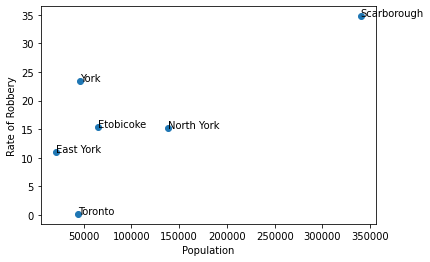

In [103]:
#Assign the x, y, and labe;s for the coordinates based on how they will be mapped
x=np.array([dfC3PopSum, dfC4PopSum, dfC5PopSum, dfC1PopSum, dfC6PopSum, dfC2PopSum])
y=np.array([dfC3CrimeAvg, dfC4CrimeAvg, dfC5CrimeAvg, dfC1CrimeAvg, dfC6CrimeAvg, dfC2CrimeAvg])
label=["Etobicoke", "Toronto", "York", "Scarborough", "East York", "North York"]
#Scatter the data
fig, ax = plt.subplots()
ax.scatter(x, y)
#Adding labels to boroughs
for i, txt in enumerate(label):
    ax.annotate(txt, (x[i], y[i]))
#Labeling x and y axis
plt.ylabel("Rate of Robbery")
plt.xlabel("Population")
#Display plot
plt.show()

<h4>
Extra topic: Relation between robbery between higher population and fewer police stations
</h4>

In [104]:
#Create the map which will have markers for the clustered data and the police stations
mapClusterWithStations = folium.Map(location=[latitude, longitude], zoom_start=10)
#Adding colours to be assigned to each borough
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Marker will have cluster number, borough, neighbourhood, and robbery average
#Looping through data frame and grabbing the required data for mapping and labeling
markers_colors = []
for lat, lon, neighbourhood, cluster, avg, pop, borough in zip(dfAll['Latitude'], dfAll['Longitude'], dfAll['Neighbourhood'], dfAll['Cluster_Labels'], dfAll['properties.Robbery_AVG'], dfAll["properties.Population"], dfAll["Borough"]):
    label = folium.Popup('Cluster:' + str(cluster) +"\n" + 'Borough:' + str(borough) +"\n" + "neighbourhood:" + str(neighbourhood) +"\n" + "Robbery avg:" + str(avg) + "\n"  + "Population:" + str(pop), parse_html=True, max_width=300, max_height=300)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mapClusterWithStations)
    
#Adding markers for police stations 
#Will display the stations' name on click
for name, latitude, longitude in zip(dfStations['name'], dfStations['geocodes.main.latitude'], dfStations['geocodes.main.longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [latitude,longitude],
    radius=5,
    popup=label,
    color='black',
    fill=True,
    fill_color='black',
    fill_opacity=0.7,
    parse_html=False).add_to(mapClusterWithStations)
       
mapClusterWithStations